In [7]:
from pathlib import Path
import rasterio as rio
from matplotlib import pyplot as plt
from omnicloudmask import (
    predict_from_load_func,
    load_s2,
)
from s2dl import fetch_single_sentinel_product

In [2]:
test_data_dir = Path.cwd() / "Sentinel-2 data"
test_data_dir.mkdir(exist_ok=True, parents=True)

Download a Sentinel-2 scene, note the OmniCloudMask supports both L1C and L2A processing levels.


In [3]:
product_id = "S2A_MSIL1C_20230304T020441_N0509_R017_T50HNH_20230304T051523"
scene_dir = test_data_dir / (product_id + ".SAFE")
if not (test_data_dir / (product_id + ".SAFE")).exists():
    fetch_single_sentinel_product(
        product_id,
        test_data_dir,
    )
scene_dir

PosixPath('/Users/nick/Documents/Projects/OmniCloudMask/Sentinel-2 data/S2A_MSIL1C_20230304T020441_N0509_R017_T50HNH_20230304T051523.SAFE')

Perform inference with 'predict_from_load_func' function, this operation is intended to process multiple scenes, but we will just pass int a list of length 1.

This function also requires a 'load_func' which is used to open the scene and return a Red, Green and NIR numpy array as well as a rasterio profile used to save the output mask.

OmniCloudMask has built in load funcs for Sentinel-2, Landsat 8 and Multiband imagery (a single geotiff with multiple bands).

This should work on any hardware, however a recent NVIDIA GPU will make it a lot faster.


In [4]:
pred_paths = predict_from_load_func(
    scene_paths=[scene_dir], load_func=load_s2, inference_dtype="bf16"
)

Running inference using mps bfloat16: 100%|██████████| 1/1 [04:44<00:00, 284.10s/it]


Display the RGB scene along with the cloud and cloud shadow mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4285713].


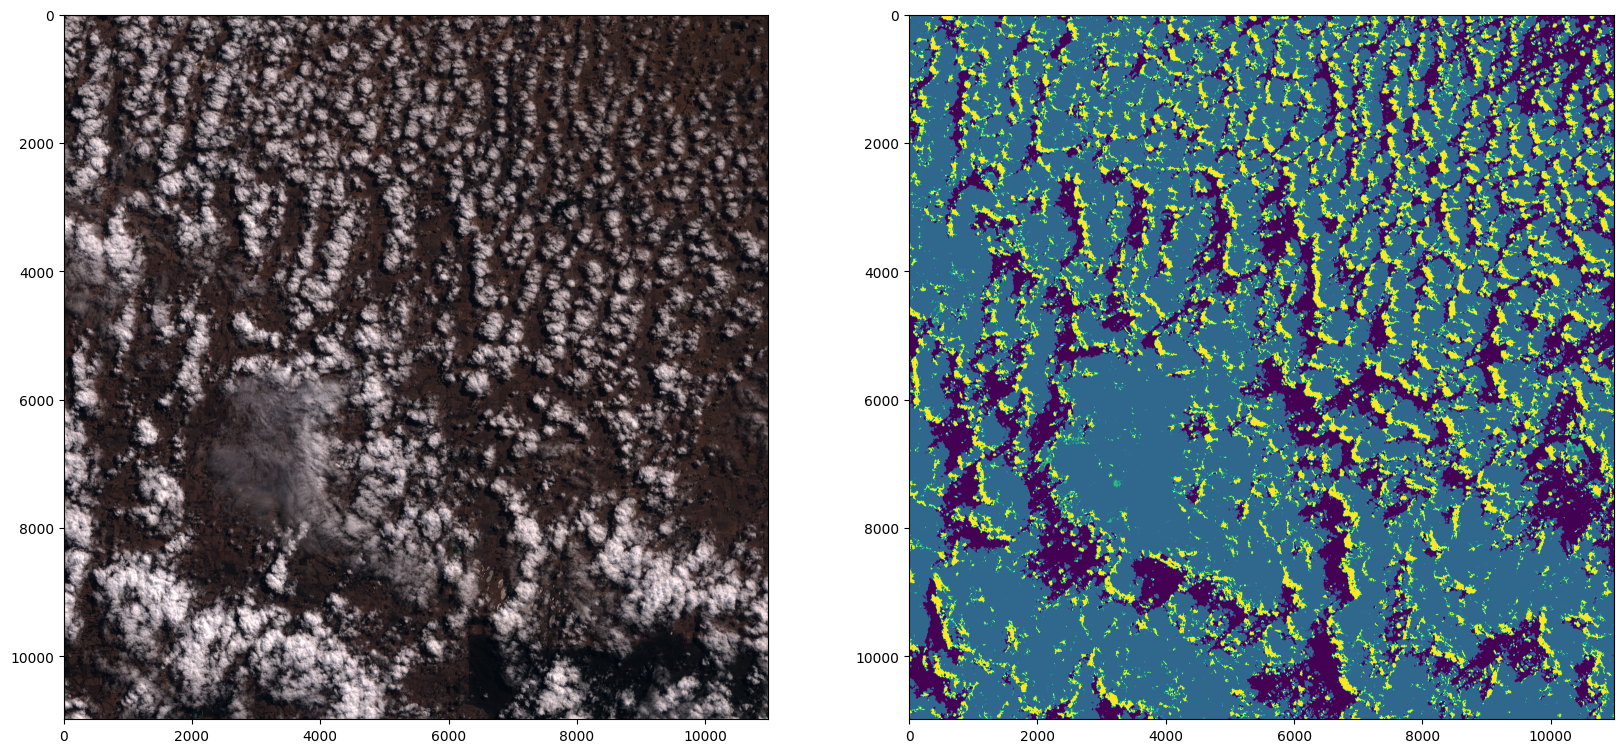

In [5]:
scene_RGB = load_s2(scene_dir, required_bands=["B04", "B03", "B02"])[0].astype(
    "float32"
)
scene_RGB -= scene_RGB.min()
scene_RGB /= scene_RGB.max() * 0.7

pred_array = rio.open(pred_paths[0]).read(1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(scene_RGB.transpose(1, 2, 0))
ax[1].imshow(pred_array)
plt.show()

Zoom into a small section


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008812649..1.0049495].


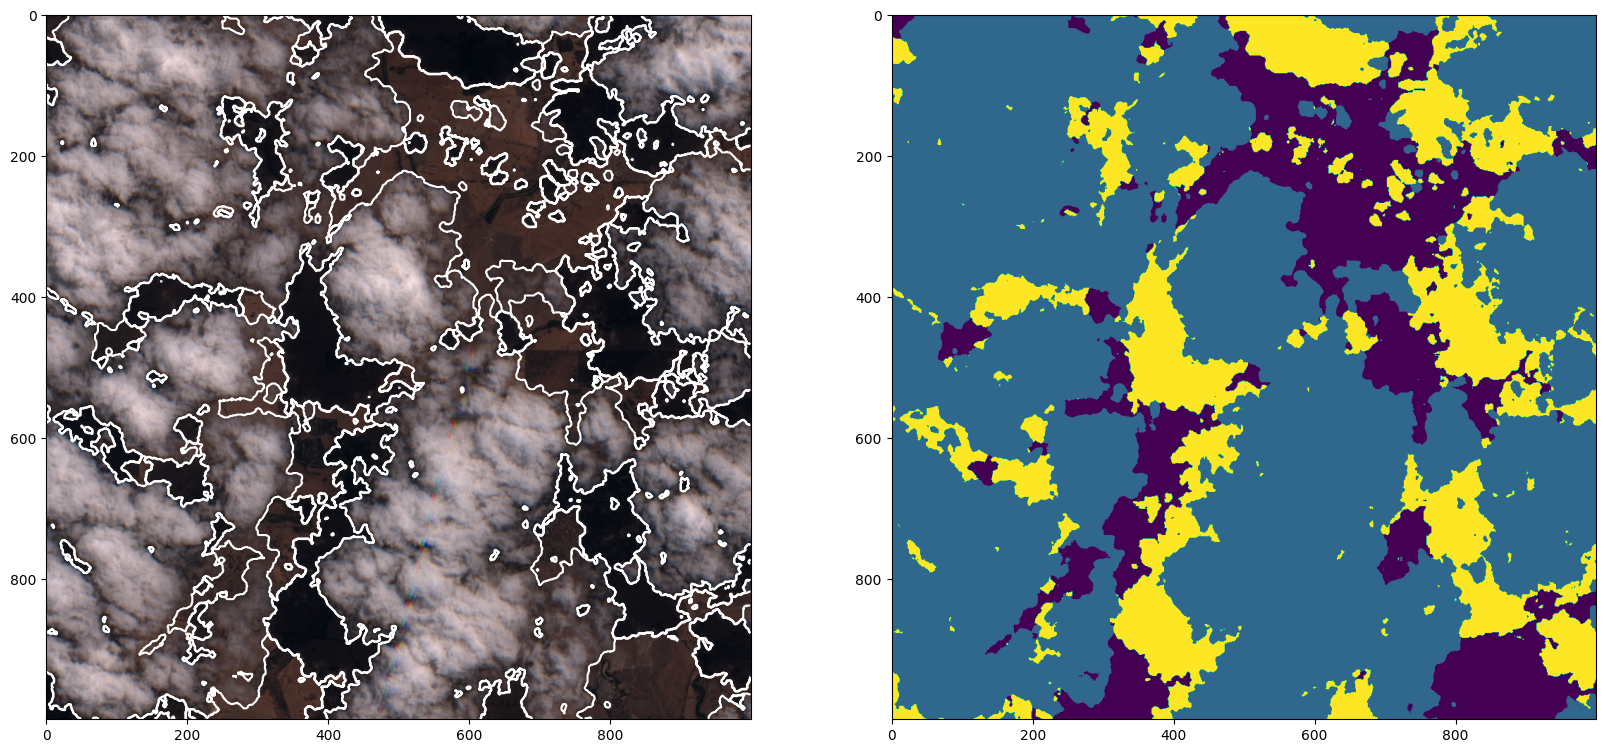

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(scene_RGB.transpose(1, 2, 0)[:1000, :1000, :])
ax[0].contour(pred_array[:1000, :1000], levels=[0, 1, 2, 3], colors="w")
ax[1].imshow(pred_array[:1000, :1000])